<a href="https://colab.research.google.com/github/sanjeetarya001/TimeSeriesdata/blob/main/TFT_complete_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Prepration and Analysis

### Importing Packages

In [ ]:
%%capture
!pip install darts

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel,NBEATSModel, NaiveSeasonal, NaiveDrift,ExponentialSmoothing,FFT
from darts.metrics import mape, rmse
from darts.utils.statistics import check_seasonality, extract_trend_and_seasonality ,plot_acf,stationarity_test_adf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression,GaussianLikelihood
from darts.utils.utils import ModelMode, SeasonalityMode, TrendMode

pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

### DataSet

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# path = '/content/drive/My Drive/TFT_files/output.csv'
path = 'https://github.com/sanjeetarya001/TimeSeriesdata/raw/main/output.csv'
df4 = pd.read_csv(path)

In [ ]:
df4

,time,price,price_dayahead,gen_coal,gen_gas,load_actual,gen_lig,gen_oil,gen_oth_renew,pressure_Barcelona,gen_hyd_pump
0,2014-12-31 23:00:00+00:00,65.41,50.10,"4,821.00","4,844.00","25,385.00",329.00,162.00,73.00,"1,035.00",863.00
1,2015-01-01 00:00:00+00:00,64.92,48.10,"4,755.00","5,196.00","24,382.00",328.00,158.00,71.00,"1,035.00",920.00
2,2015-01-01 01:00:00+00:00,64.48,47.33,"4,581.00","4,857.00","22,734.00",323.00,157.00,73.00,"1,036.00","1,164.00"
3,2015-01-01 02:00:00+00:00,59.32,42.27,"4,131.00","4,314.00","21,286.00",254.00,160.00,75.00,"1,036.00","1,503.00"
4,2015-01-01 03:00:00+00:00,56.04,38.41,"3,840.00","4,130.00","20,264.00",187.00,156.00,74.00,"1,036.00","1,826.00"
...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 18:00:00+00:00,77.02,68.85,"2,628.00","7,634.00","30,653.00",0.00,178.00,95.00,"1,027.00",1.00
35060,2018-12-31 19:00:00+00:00,76.16,68.40,"2,566.00","7,241.00","29,735.00",0.00,174.00,95.00,"1,027.00",1.00
35061,2018-12-31 20:00:00+00:00,74.30,66.88,"2,422.00","7,025.00","28,071.00",0.00,168.00,94.00,"1,028.00",50.00
35062,2018-12-31 21:00:00+00:00,69.89,63.93,"2,293.00","6,562.00","25,801.00",0.00,163.00,93.00,"1,028.00",108.00


In [ ]:
# datetime
df4["time"] = pd.to_datetime(df4["time"], utc=True, infer_datetime_format=True)
df4.set_index("time", inplace=True)

In [ ]:
f64cols = list(df4.dtypes[df4.dtypes == np.float64].index)
df4[f64cols] = df4[f64cols].applymap(np.float32)

In [ ]:
df4 = df4[df4.index >= "2018-01-01 00:00:00+00:00"]

In [ ]:
print(len(df4))

8759


### Conversion to TimeSeries

In [ ]:
# create time series object for target variable
price = TimeSeries.from_series(df4["price"])

# check attributes of the time series
print("components:", price.components)
print("duration:",price.duration)


components: Index(['price'], dtype='object', name='component')
duration: 364 days 22:00:00


In [ ]:
len(price)

8759

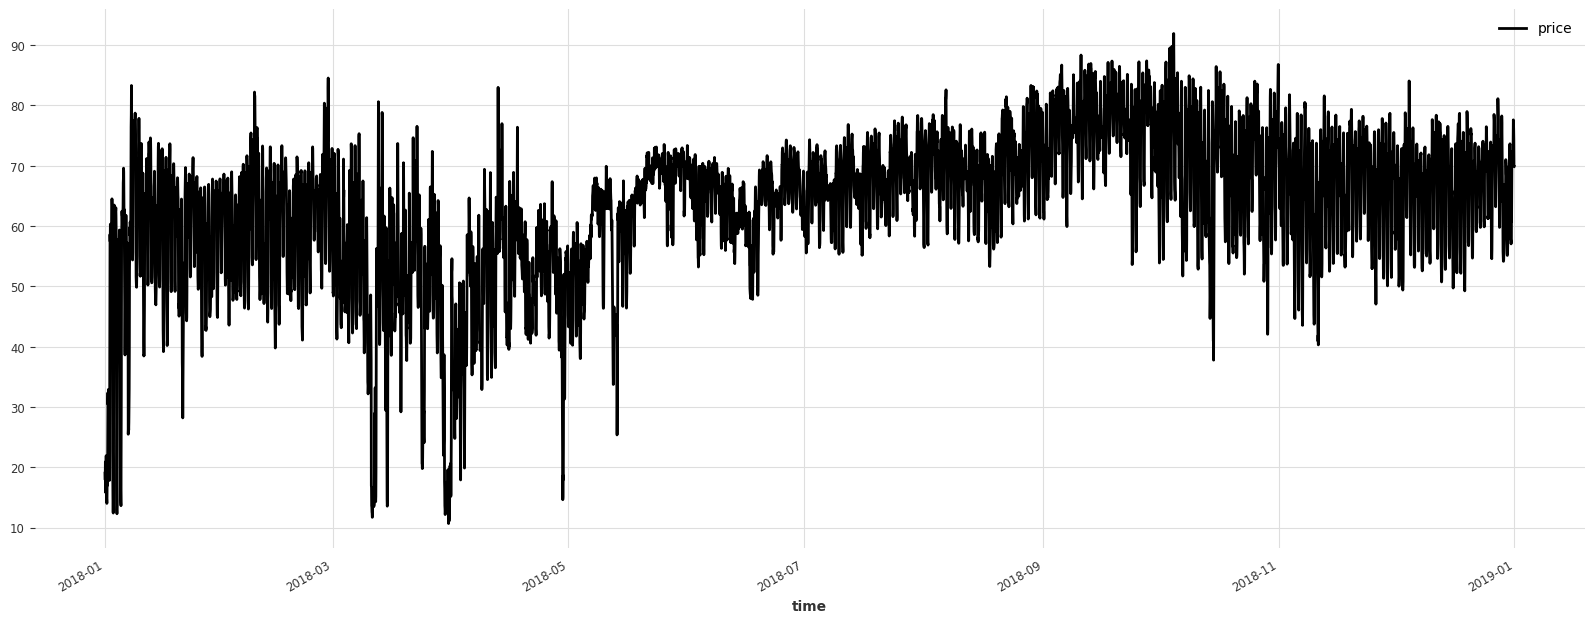

In [ ]:
plt.figure(100, figsize=(20, 7))
price.plot()

### Stationarity Check

In [ ]:
ADF_result = stationarity_test_adf(price)
print(f'ADF Statistic: {ADF_result[0]}') # it should be large negative for stationarity
print(f'p-value: {ADF_result[1]}')       # it should be less then 0.05 for stationarity

## Results shows us that we have a stationary time series so there is no need to transform it.

ADF Statistic: -6.005420097024269
p-value: 1.6198795148004842e-07


###Seasonality Check

In [ ]:
MSEAS = 200
ALPHA = 0.05
mseas=MSEAS
seasonality = []
for m in range(2, MSEAS):
    is_seasonal, mseas = check_seasonality(price, m=m, alpha=ALPHA, max_lag=MSEAS)
    if is_seasonal:
       seasonality.append(mseas)
      #  break
print(seasonality)
print("seasonal? " + str(is_seasonal))
if is_seasonal:
    print('There is seasonality of order {} hours'.format(mseas))

[11, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156, 168, 180, 192]
seasonal? False


Trend and seasonal components

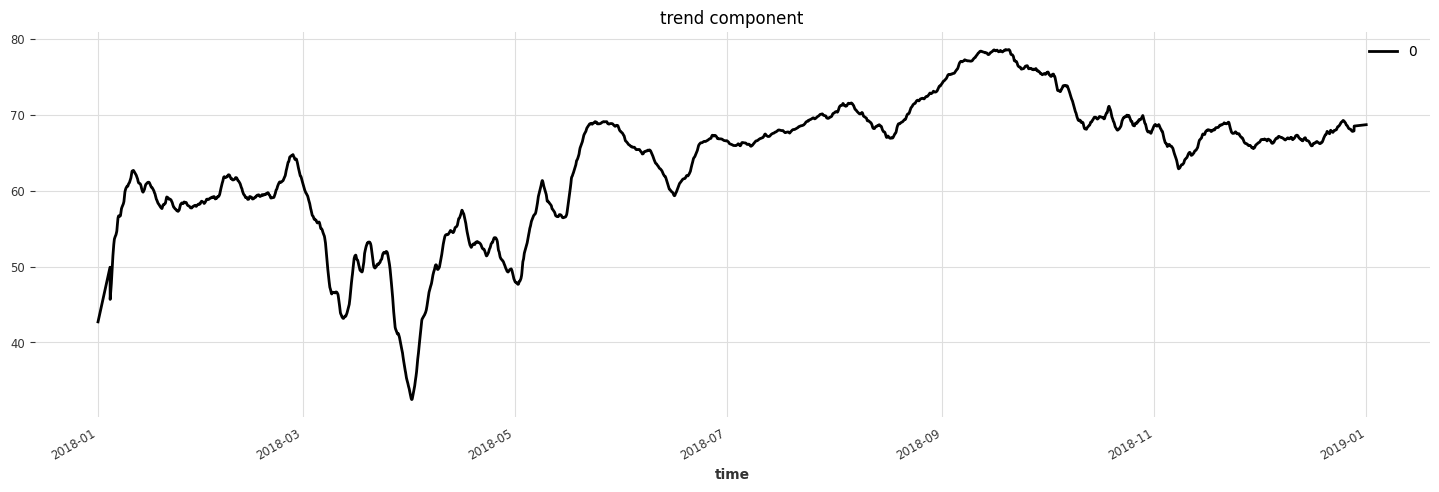

In [ ]:
trend, seas = extract_trend_and_seasonality(ts=price, freq=168)

plt.figure(100, figsize=(18, 5))
trend.plot()
plt.title("trend component");

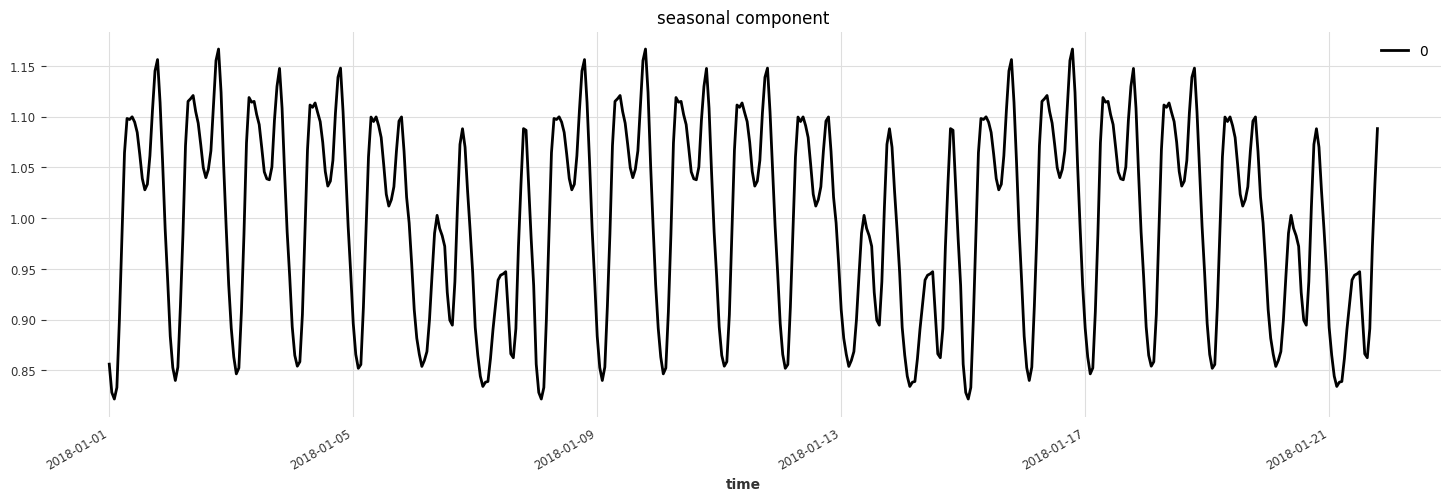

In [ ]:
plt.figure(100, figsize=(18, 5))
seas.head(500).plot()
plt.title("seasonal component");

### Covariates

In [ ]:
# create time series object for the feature columns
df_cov = df4.loc[:, df4.columns != "price"]
covariates = TimeSeries.from_dataframe(df_cov)

In [ ]:
covariates.columns

Index(['price_dayahead', 'gen_coal', 'gen_gas', 'load_actual', 'gen_lig',
       'gen_oil', 'gen_oth_renew', 'pressure_Barcelona', 'gen_hyd_pump'],
      dtype='object', name='component')

In [ ]:
covariates.n_components

9

In [ ]:
# rescale the covariates: fit on the training set
scaler = Scaler()
scaler.fit(covariates)
covariates = scaler.transform(covariates)

### Train/Test Split (Target Variable)

In [ ]:
target_train, target_test = price.split_after(0.9)
print("training start:", target_train.start_time())
print("training end:", target_train.end_time())
print("training duration:",target_train.duration)
print("test start:", target_test.start_time())
print("test end:", target_test.end_time())
print("test duration:", target_test.duration)

training start: 2018-01-01 00:00:00
training end: 2018-11-25 10:00:00
training duration: 328 days 10:00:00
test start: 2018-11-25 11:00:00
test end: 2018-12-31 22:00:00
test duration: 36 days 11:00:00


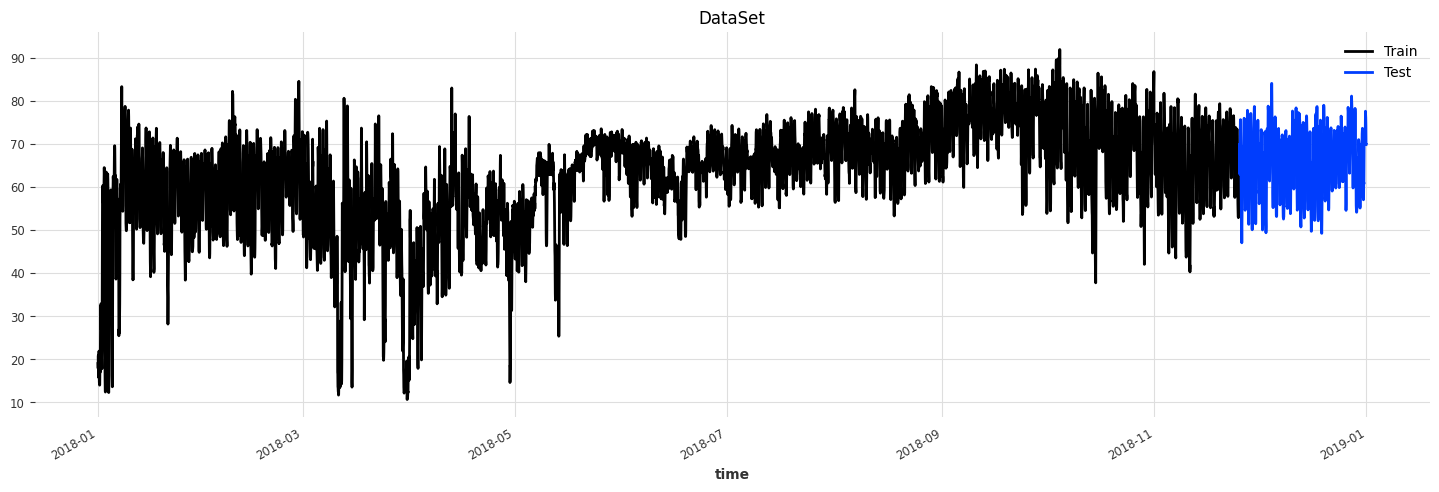

In [ ]:
plt.figure(100, figsize=(18, 5))
target_train.plot(label="Train")
target_test.plot(label="Test")
plt.title("DataSet");

### Scaling (Between 0 and 1)

In [ ]:
scalerPrice = Scaler()
scalerPrice.fit(target_train)
trans_target_train = scalerPrice.transform(target_train)
trans_target_test = scalerPrice.transform(target_test)
trans_price = scalerPrice.transform(price)

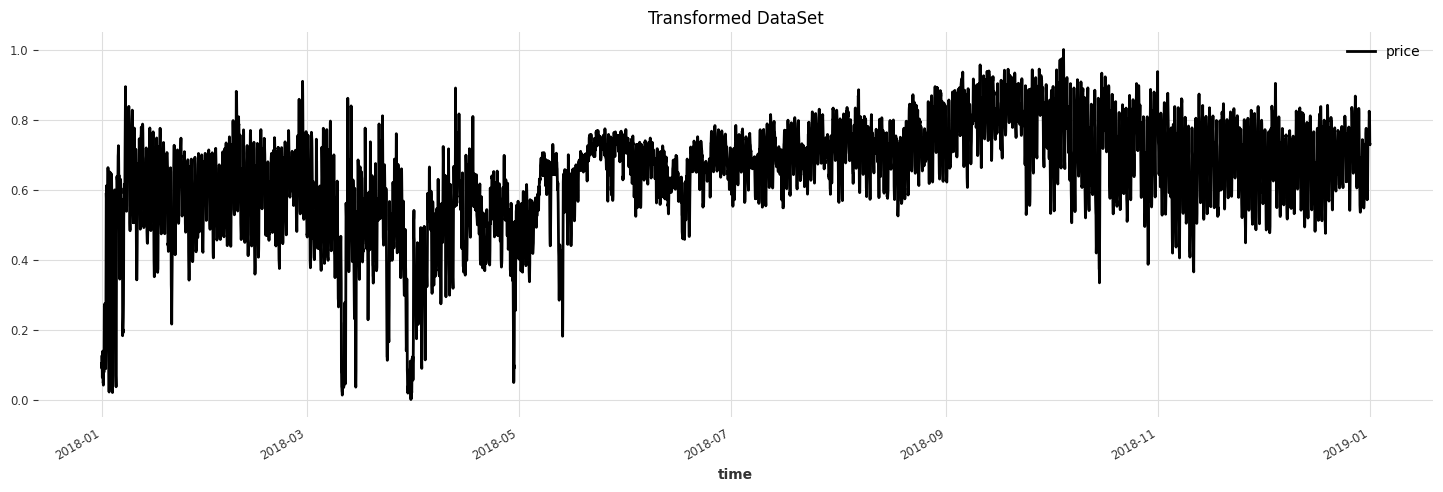

In [ ]:
plt.figure(100, figsize=(18, 5))
trans_price.plot()
plt.title("Transformed DataSet");

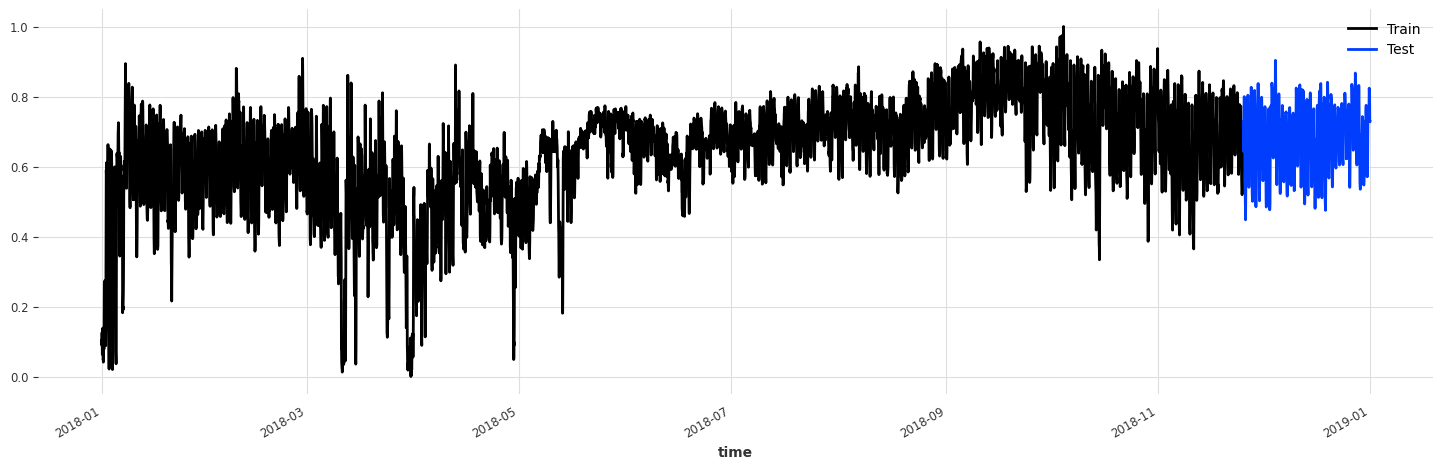

In [ ]:
plt.figure(100, figsize=(18, 5))
trans_target_train.plot(label="Train")
trans_target_test.plot(label="Test")

In [ ]:
# Spliting the train dataset into final_train and validation set
final_train , final_val = trans_target_train.split_after(0.8)
print("training start:", final_train.start_time())
print("training end:", final_train.end_time())
print("training duration:",final_train.duration)
print("Validation start:", final_val.start_time())
print("Validation end:", final_val.end_time())
print("Validation duration:", final_val.duration)

training start: 2018-01-01 00:00:00
training end: 2018-09-20 17:00:00
training duration: 262 days 17:00:00
Validation start: 2018-09-20 18:00:00
Validation end: 2018-11-25 10:00:00
Validation duration: 65 days 16:00:00


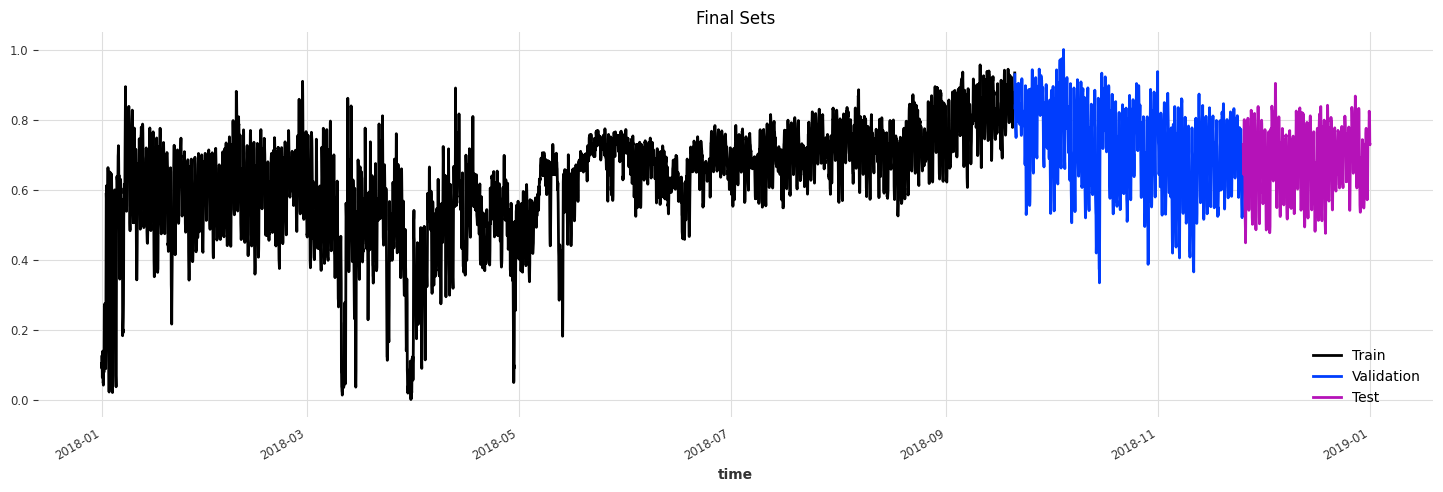

In [ ]:
plt.figure(100, figsize=(18, 5))
final_train.plot(label="Train")
final_val.plot(label = 'Validation')
trans_target_test.plot(label="Test")
plt.title("Final Sets");

# TFT Model

### Parameters

In [ ]:
EPOCHS = 3
INLEN = 168          # input size
HIDDEN = 64       # hidden layers
LSTMLAYERS = 1      # recurrent layers
ATTH = 4            # attention heads
BATCH = 64          # batch size
LEARN = 1e-3        # learning rate
DROPOUT = 0.1       # dropout rate
VALWAIT = 1         # epochs to wait before evaluating the loss on the test/validation set
N_FC = 24          # output size

RAND = 42           # random seed
N_SAMPLES = 100     # number of times a prediction is sampled from a probabilistic model
N_JOBS = -1          # parallel processors to use;  -1 = all processors

# default quantiles for QuantileRegression
QUANTILES = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99]

qL1, qL2 = 0.01, 0.10        # percentiles of predictions: lower bounds
qU1, qU2 = 1-qL1, 1-qL2,     # upper bounds derived from lower bounds
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'

### Instantiating

In [ ]:
TFT = TFTModel(     input_chunk_length=INLEN,
                    output_chunk_length=N_FC,
                    hidden_size=HIDDEN,
                    lstm_layers=LSTMLAYERS,
                    num_attention_heads=ATTH,
                    dropout=DROPOUT,
                    batch_size=BATCH,
                    n_epochs=EPOCHS,
                    nr_epochs_val_period=VALWAIT,
                    likelihood=QuantileRegression(QUANTILES),
                    optimizer_kwargs={"lr": LEARN},
                    model_name="TFT_EnergyES",
                    log_tensorboard=True,
                    random_state=RAND,
                    force_reset=True,
                    add_relative_index =  True,
                    save_checkpoints=True
                )

###Training

In [ ]:
TFT.fit( series=final_train,
         past_covariates=covariates,
         val_series=final_val,
         val_past_covariates=covariates,
         verbose=True
        )

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

TFTModel(hidden_size=64, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=True, loss_fn=None, likelihood=<darts.utils.likelihood_models.QuantileRegression object at 0x7f3f9b9404c0>, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=168, output_chunk_length=24, batch_size=64, n_epochs=3, nr_epochs_val_period=1, optimizer_kwargs={'lr': 0.001}, model_name=TFT_EnergyES, log_tensorboard=True, random_state=42, force_reset=True, save_checkpoints=True)

### Predicting

In [ ]:
# testing: generate predictions
predicted_horizon = TFT.predict(   n=len(final_val),
                                   series = final_train,
                                   past_covariates=covariates,
                                   num_samples=N_SAMPLES,
                                   n_jobs=N_JOBS,
                                   verbose=True
                               )

Predicting: 0it [00:00, ?it/s]

### Result Analysis

In [ ]:
print(mape(final_val,predicted_horizon))

18.581329454746193


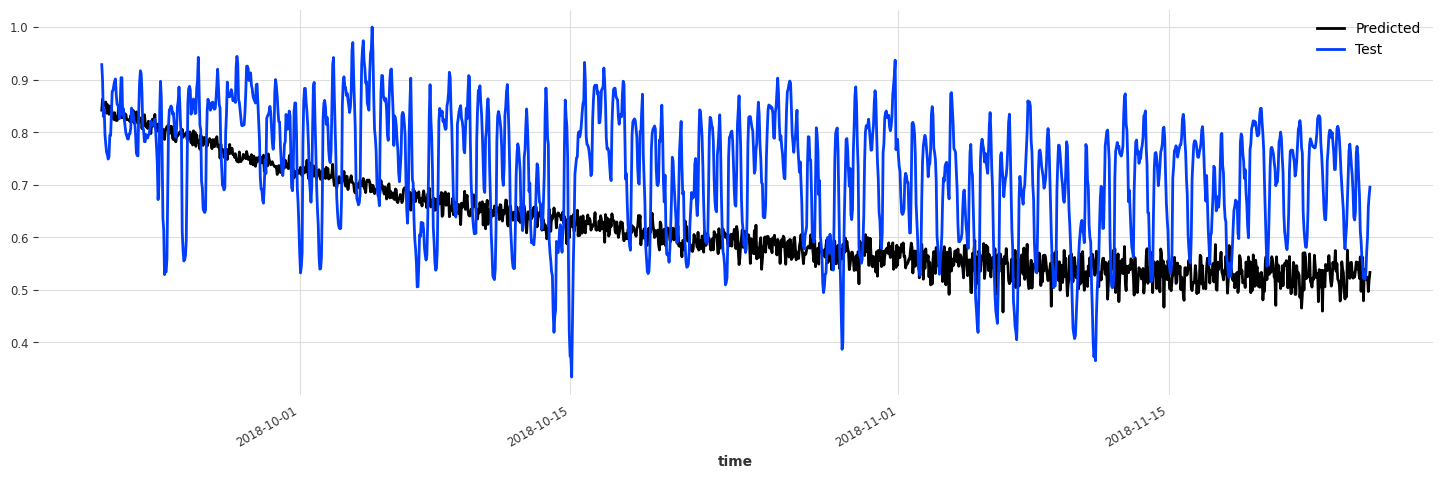

In [ ]:
plt.figure(100, figsize=(18, 5))
predicted_horizon.quantile_timeseries(0.5).plot(label = 'Predicted')
final_val.plot(label = 'Test')

In [ ]:
# Transforming the data back to original scale

In [ ]:
val = scalerPrice.inverse_transform(final_val)
horizon = scalerPrice.inverse_transform(predicted_horizon.quantile_timeseries(0.5))
print(mape(val,horizon))

15.73882833136166


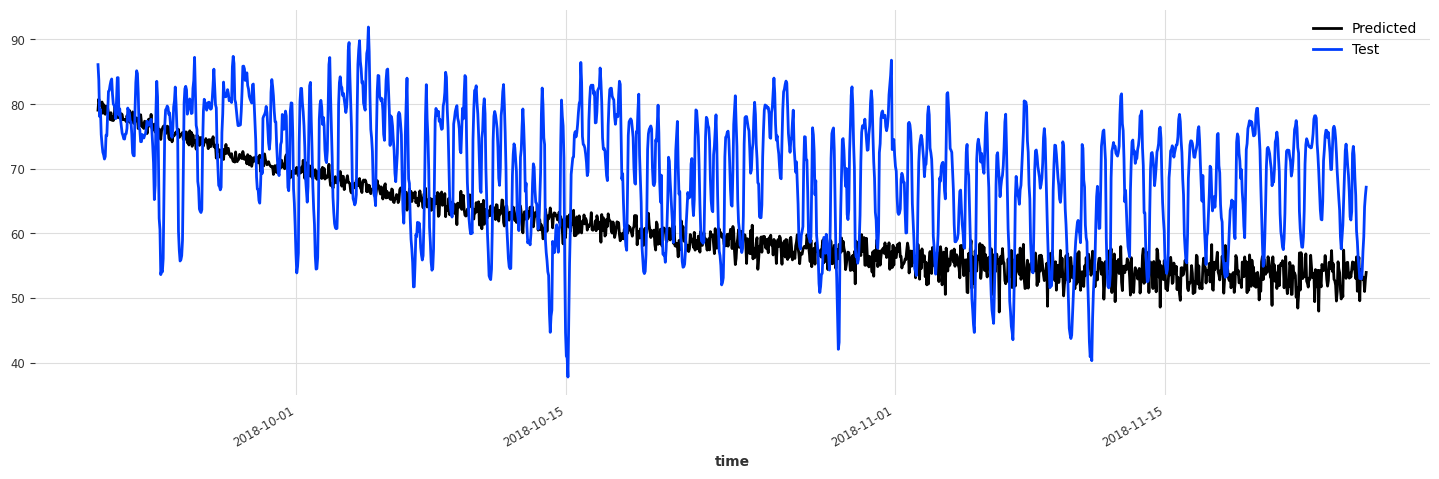

In [ ]:
plt.figure(100, figsize=(18, 5))
horizon.plot(label = 'Predicted')
val.plot(label = 'Test')

# Tunning

### Getting New Parameters Using optuna

In [ ]:
%%capture
!pip install -U optuna

In [ ]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.visualization import (
    plot_optimization_history,
    plot_contour,
    plot_param_importances,
)
import torch
import random
from tqdm.notebook import tqdm
from pytorch_lightning.callbacks import Callback, EarlyStopping
from sklearn.preprocessing import MaxAbsScaler

In [ ]:
EPOCHS = 3
INLEN = 168          # input size
HIDDEN = 64       # hidden layers
LSTMLAYERS = 1      # recurrent layers
ATTH = 4            # attention heads
BATCH = 64          # batch size
LEARN = 1e-3        # learning rate
DROPOUT = 0.1       # dropout rate
VALWAIT = 1         # epochs to wait before evaluating the loss on the test/validation set
N_FC = 24          # output size

RAND = 42           # random seed
N_SAMPLES = 100     # number of times a prediction is sampled from a probabilistic model
N_JOBS = -1          # parallel processors to use;  -1 = all processors

# default quantiles for QuantileRegression
QUANTILES = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99]

qL1, qL2 = 0.01, 0.10        # percentiles of predictions: lower bounds
qU1, qU2 = 1-qL1, 1-qL2,     # upper bounds derived from lower bounds
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'

In [ ]:
def objective(trial):
    callback = [PyTorchLightningPruningCallback(trial, monitor="val_loss")]

    # reproducibility
    torch.manual_seed(42)

    # set input_chunk_length, between 5 and 14 days
    days_in = trial.suggest_int("days_in", 5, 21)
    in_len = days_in * 24

    # set out_len, between 1 and 13 days (it has to be strictly shorter than in_len).
    days_out = trial.suggest_int("days_out", 1, days_in - 1)
    out_len = days_out * 12

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 32, 256)
    lstm_layers = trial.suggest_int("lstm_layers", 1,4)
    #weight_norm = trial.suggest_categorical("weight_norm", [False, True])
    num_attention_heads = trial.suggest_int("num_attention_heads", 1, 4)
    dropout = trial.suggest_float("dropout", 0.0, 0.4)
    lr = trial.suggest_float("lr", 5e-5, 1e-3, log=True)
    #include_dayofweek = trial.suggest_categorical("dayofweek", [False, True])

    # throughout training we'll monitor the validation loss for early stopping
    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=3, verbose=True)
    if callbacks is None:
        callbacks = [early_stopper]
    else:
        callbacks = [early_stopper] + callbacks

    # detect if a GPU is available
    if torch.cuda.is_available():
        pl_trainer_kwargs = {
            "accelerator": "gpu",
            "gpus": -1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
        }
        num_workers = 4
    else:
        pl_trainer_kwargs = {"callbacks": callbacks}
        num_workers = 0

    # build and train the TFT model with these hyper-parameters:
    TFT = TFTModel( input_chunk_length=in_len,
                    output_chunk_length=out_len,
                    hidden_size=hidden_size,
                    lstm_layers=lstm_layers,
                    num_attention_heads=num_attention_heads,
                    dropout=dropout,
                    batch_size=BATCH,
                    n_epochs=EPOCHS,
                    nr_epochs_val_period=VALWAIT,
                    likelihood=QuantileRegression(QUANTILES),
                    optimizer_kwargs={"lr": lr},
                    model_name="TFT_EnergyES",
                    pl_trainer_kwargs=pl_trainer_kwargs,
                    log_tensorboard=True,
                    random_state=RAND,
                    force_reset=True,
                    add_relative_index =  True,
                    save_checkpoints=True
                )

    TFT.fit( series=final_train,
         past_covariates=covariates,
         val_series=final_val,
         val_past_covariates=covariates,
         verbose=True
        )
    # testing: generate predictions
    predicted_horizon = TFT.predict(   n=len(final_val),
                                   series = final_train,
                                   num_samples=N_SAMPLES,
                                   n_jobs=N_JOBS,
                                   verbose=True
                               )
    # Evaluate how good it is on the validation set

    mape_val = mape(final_val, predicted_horizon, n_jobs=-1, verbose=True)


    return mape_val if mape_val != np.nan else float("inf")

In [ ]:
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


study = optuna.create_study(direction="minimize")

#study.optimize(objective, timeout=300, callbacks=[print_callback])

# We could also have used a command as follows to limit the number of trials instead:
study.optimize(objective, n_trials=10, callbacks=[print_callback])

# Finally, print the best value and best hyperparameters:
print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
#Best value: 13.737644039566394, Best params: {'days_in': 17, 'days_out': 14, 'hidden_size': 51, 'lstm_layers': 4, 'num_attention_heads': 1, 'dropout': 0.0006347386327369087, 'lr': 0.0006705254531248372}

### After tunning

In [ ]:
TFT = TFTModel(     input_chunk_length=17*24,
                    output_chunk_length=14*24,
                    hidden_size=51,
                    lstm_layers=4,
                    num_attention_heads=1,
                    dropout=0.0006347386327369087,
                    batch_size=BATCH,
                    n_epochs=EPOCHS,
                    nr_epochs_val_period=VALWAIT,
                    likelihood=QuantileRegression(QUANTILES),
                    optimizer_kwargs={"lr": 0.0006705254531248372},
                    model_name="TFT_EnergyES",
                    log_tensorboard=True,
                    random_state=RAND,
                    force_reset=True,
                    add_relative_index =  True,
                    save_checkpoints=True
                )

TFT.fit( series=final_train,
         past_covariates=covariates,
         val_series=final_val,
         val_past_covariates=covariates,
         verbose=True
        )

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

TFTModel(hidden_size=51, lstm_layers=4, num_attention_heads=1, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.0006347386327369087, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=True, loss_fn=None, likelihood=<darts.utils.likelihood_models.QuantileRegression object at 0x7f3fff2145b0>, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=408, output_chunk_length=336, batch_size=64, n_epochs=3, nr_epochs_val_period=1, optimizer_kwargs={'lr': 0.0006705254531248372}, model_name=TFT_EnergyES, log_tensorboard=True, random_state=42, force_reset=True, save_checkpoints=True)

In [ ]:
predicted_horizon = TFT.predict(   n=len(final_val),
                                   series = final_train,
                                   num_samples=N_SAMPLES,
                                   n_jobs=N_JOBS,
                                   verbose=True
                               )

Predicting: 0it [00:00, ?it/s]

In [ ]:
print(mape(final_val,predicted_horizon))

14.460403641560585


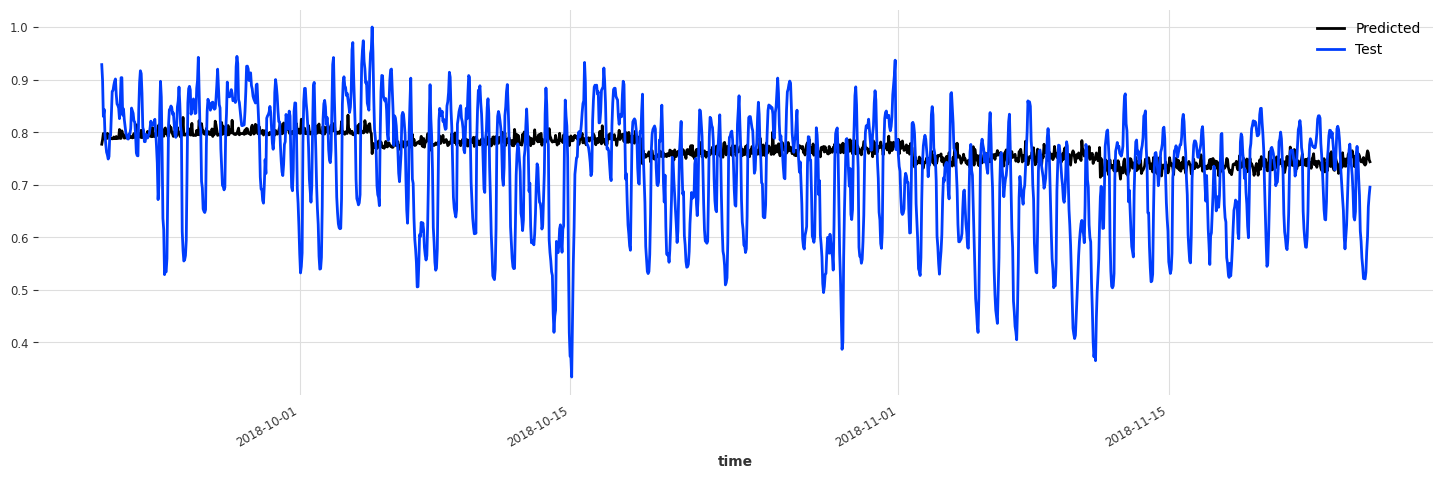

In [ ]:
plt.figure(100, figsize=(18, 5))
predicted_horizon.quantile_timeseries(0.5).plot(label = 'Predicted')
final_val.plot(label = 'Test')

### Grid Search

In [ ]:
# randomized gridsearch
parameters = {  "input_chunk_length":[72, 168],
                "output_chunk_length":[24,48],
                "hidden_size":[32, 64],
                "lstm_layers":[1],
                "num_attention_heads":[2, 3],
                "dropout":[0.1],
                "batch_size":[32, 64],
                "n_epochs":[3]
              }

res = TFTModel.gridsearch(
                            parameters=parameters,
                            series=final_train,
                            future_covariates=covariates,
                            val_series=final_val,
                            start=0.5,                 # starting point in training set
                            last_points_only=False,
                            metric=mape,
                            reduction=np.mean,
                            n_jobs=N_JOBS,
                            n_random_samples=0.99,      # % of full search space to evaluate
                            verbose=True
                          )


In [ ]:
bestmodel , dict_bestparams,value = res

In [ ]:
dict_bestparams

{'input_chunk_length': 168,
 'output_chunk_length': 24,
 'hidden_size': 64,
 'lstm_layers': 1,
 'num_attention_heads': 2,
 'dropout': 0.1,
 'batch_size': 64,
 'n_epochs': 3}

In [ ]:
bestmodel._model_params

OrderedDict([('hidden_size', 64),
             ('lstm_layers', 1),
             ('num_attention_heads', 2),
             ('full_attention', False),
             ('feed_forward', 'GatedResidualNetwork'),
             ('dropout', 0.1),
             ('hidden_continuous_size', 8),
             ('categorical_embedding_sizes', None),
             ('add_relative_index', False),
             ('loss_fn', None),
             ('likelihood', None),
             ('norm_type', 'LayerNorm'),
             ('use_static_covariates', True),
             ('input_chunk_length', 168),
             ('output_chunk_length', 24),
             ('batch_size', 64),
             ('n_epochs', 3)])

In [ ]:
# training
bestmodel.fit( series=final_train,
               future_covariates=covariates,
               past_covariates=covariates,
               val_series=final_val,
               val_future_covariates=covariates,
               verbose=True
             )

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

TFTModel(hidden_size=64, lstm_layers=1, num_attention_heads=2, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=168, output_chunk_length=24, batch_size=64, n_epochs=3)

In [ ]:
pred =  bestmodel.predict(len(final_val),future_covariates = covariates)

MAPE = "MAPE after randomized gridsearch: {:.2f}%".format(mape(final_val, pred))

# optuna

### Without Tunning TFT Model

In [ ]:
%%capture
!pip install -U optuna

In [ ]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.visualization import (
    plot_optimization_history,
    plot_contour,
    plot_param_importances,
)


In [ ]:
import torch
import random
from tqdm.notebook import tqdm
from pytorch_lightning.callbacks import Callback, EarlyStopping
from sklearn.preprocessing import MaxAbsScaler

In [ ]:
""" We write a function to build and fit a TFT Model, which we will re-use later.
"""


def build_fit_tft_model(
    in_len,
    out_len,
    hidden_size,
    batch_size,
    lstm_layers,
    num_attention_heads,
    dropout,
    lr,
    cov,
    likelihood=None,
    callbacks=None
):

    # reproducibility
    torch.manual_seed(42)

    # some fixed parameters that will be the same for all models
    #BATCH_SIZE = 64
    MAX_N_EPOCHS = 5
    NR_EPOCHS_VAL_PERIOD = 1
    MAX_SAMPLES_PER_TS = 100

    # throughout training we'll monitor the validation loss for early stopping
    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=3, verbose=True)
    if callbacks is None:
        callbacks = [early_stopper]
    else:
        callbacks = [early_stopper] + callbacks

    # detect if a GPU is available
    if torch.cuda.is_available():
        pl_trainer_kwargs = {
            "accelerator": "gpu",
            "gpus": -1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
        }
        num_workers = 4
    else:
        pl_trainer_kwargs = {"callbacks": callbacks}
        num_workers = 0

    # optionally also add the day of the week (cyclically encoded) as a future covariate

    encoders={
    'cyclic': {'future': ['month']},
    'datetime_attribute': {'future': ['hour', 'dayofweek']},
    'transformer': Scaler()}

    # build the TCN model
    model = TFTModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=batch_size,
        n_epochs=MAX_N_EPOCHS,
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        lstm_layers = lstm_layers,
        num_attention_heads = num_attention_heads,
        hidden_size= hidden_size,
        dropout=dropout,
        optimizer_kwargs={"lr": lr},
        add_encoders=encoders,
        likelihood=likelihood,
        pl_trainer_kwargs=pl_trainer_kwargs,
        model_name="tft_model",
        force_reset=True,
        save_checkpoints=True,
    )

    # when validating during training, we can use a slightly longer validation
    # set which also contains the first input_chunk_length time steps
    model_val_set = price[(final_val.start_time()-pd.Timedelta(in_len, unit=price.freq_str)  ):(final_val.end_time())]

    # train the model
    model.fit(
        series=final_train,
        past_covariates = cov,
        val_series=model_val_set,
        val_past_covariates = cov,
        max_samples_per_ts=MAX_SAMPLES_PER_TS,
        num_loader_workers=num_workers,
    )

    # reload best model over course of training
    model = TFTModel.load_from_checkpoint("tft_model")

    return model

In [ ]:
def eval_model(preds, name, train_set=final_train, val_set=final_val):
    mapes = mape(preds, val_set)
    print("{} MAPE: {:.2f}".format(name,mapes))
    plt.figure(figsize=(15, 5))
    train_set[-7 * 24 :].plot()
    val_set.plot(label="actual")
    preds.plot(label="forecast")


In [ ]:
model = build_fit_tft_model(
                    in_len=17*24,
                    out_len=14*24,
                    hidden_size=51,
                    lstm_layers=4,
                    batch_size=64,
                    num_attention_heads=1,
                    dropout=0.0006347386327369087,
                    lr=0.0006705254531248372,
                    cov = covariates,

                           )

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### Predict

In [ ]:
preds = model.predict(series=final_train, n=len(final_val))


Predicting: 0it [00:00, ?it/s]

### Results

First TFT model MAPE: 361.40


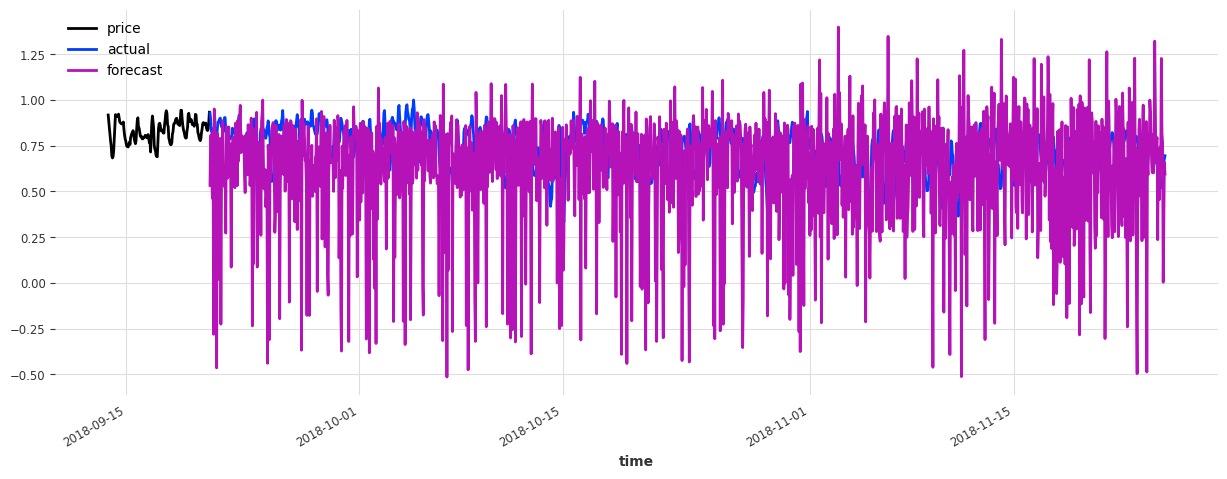

In [ ]:
eval_model(preds, "First TFT model")

### Tunning Starts

In [ ]:
# %%capture
# !pip install torch pytorch-lightning

In [ ]:
def objective(trial):
    callback = [PyTorchLightningPruningCallback(trial, monitor="val_loss")]

    # set input_chunk_length, between 5 and 14 days
    days_in = trial.suggest_int("days_in", 5, 21)
    in_len = days_in * 24

    # set out_len, between 1 and 13 days (it has to be strictly shorter than in_len).
    days_out = trial.suggest_int("days_out", 1, days_in - 1)
    out_len = days_out * 12

    # Other hyperparameters
    hidden_size = trial.suggest_categorical("hidden_size", [32,64,128,256])
    batch_size = trial.suggest_categorical("batch_size", [32,64,128,256])
    lstm_layers = trial.suggest_int("lstm_layers", 1,4)
    #weight_norm = trial.suggest_categorical("weight_norm", [False, True])
    num_attention_heads = trial.suggest_int("num_attention_heads", 1, 4)
    dropout = trial.suggest_float("dropout", 0.0, 0.4)
    lr = trial.suggest_float("lr", 5e-5, 1e-3, log=True)
    #include_dayofweek = trial.suggest_categorical("dayofweek", [False, True])

    # build and train the TFT model with these hyper-parameters:
    model = build_fit_tft_model(
                    in_len=in_len,
                    out_len=out_len,
                    hidden_size=hidden_size,
                    batch_size = batch_size,
                    lstm_layers=lstm_layers,
                    num_attention_heads=num_attention_heads,
                    dropout=dropout,
                    lr=lr,
                    cov = covariates,
    )

    # Evaluate how good it is on the validation set
    preds = model.predict(series=final_train, n=len(final_val))
    mape_val = mape(final_val, preds, n_jobs=-1, verbose=True)


    return mape_val if mape_val != np.nan else float("inf")

### Optimizer

In [ ]:
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


study = optuna.create_study(direction="minimize")

#study.optimize(objective, timeout=300, callbacks=[print_callback])

# We could also have used a command as follows to limit the number of trials instead:
study.optimize(objective, n_trials=5, callbacks=[print_callback])

In [ ]:
#Best value: 50.78832507133484, Best params: {'days_in': 9, 'days_out': 5, 'hidden_size': 152, 'lstm_layers': 1, 'num_attention_heads': 2, 'dropout': 0.2640101759571141, 'lr': 0.0003958863851209147}


### Best parameters

In [ ]:
# Finally, print the best value and best hyperparameters:
print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

### TFT Model After Tunning

In [ ]:
model = build_fit_tft_model(
                    in_len=15*24,
                    out_len=7*24,
                    hidden_size=255,
                    lstm_layers=2,
                    batch_size=64,
                    num_attention_heads=3,
                    dropout=0.045560413888965194,
                    lr=0.00031718745990300275,
                    cov = covariates,

                           )

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### Predict

In [ ]:
preds = model.predict(series=final_train, n=len(final_val))

Predicting: 0it [00:00, ?it/s]

### Results

First TFT model MAPE: 34.60


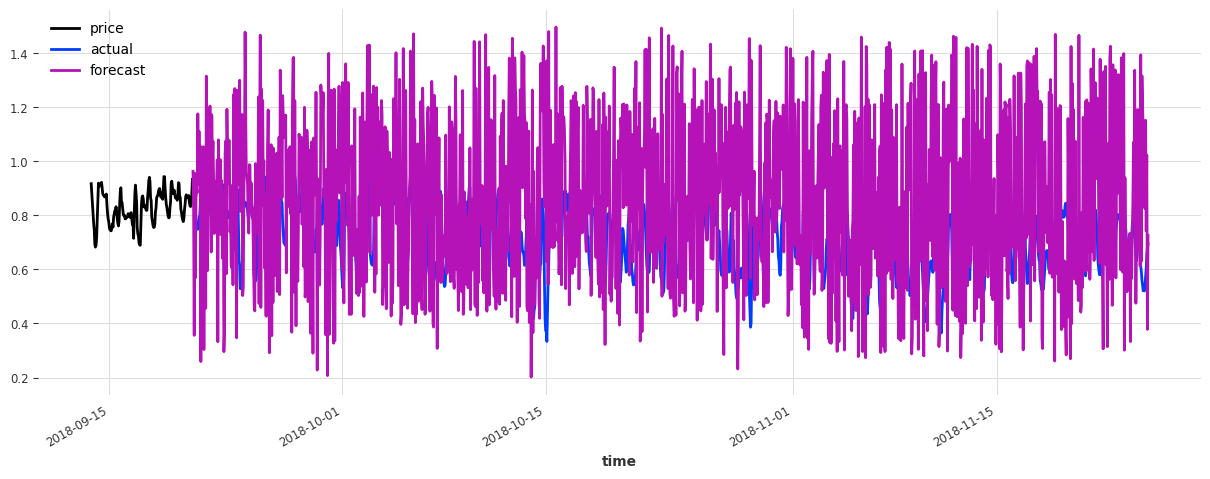

In [ ]:
eval_model(preds, "First TFT model")